#### ANL Sprint 2017

HSC-DR1 LSS Sprint:
Addressing the first task here:
https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS/blob/master/SprintWeekDiary.md, that is comparingg Depth (limiting magnitude) from three methods:
1. Using Javi's method
2. Binning 5*flux_error for all galaxies in each pixel.
3. Using the random sky_std as described in https://hsc-release.mtk.nao.ac.jp/doc/index.php/random-points-for-dr1/. 
4. Use the method used in HSC-DR1 paper: 5sigma depth= mean of mag of galaxies with 4<SNR<6.

For each of these, we have the mean depth and depth variance for the $i$ band.

#### Here: calculate the twoPt corr from the three methods to see how they compare.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits

from astropy.table import Table
import healpy as hp
from collections import OrderedDict
from matplotlib import cm
import copy

from dataCleanUp import dataCleanUp
from addSNR import addSNR
from createMaps import createMeanStdMaps
from mpl_toolkits.axes_grid1 import ImageGrid
from twoPtCorr import runTreeCorr
from plots import plot_wtheta
import flatmaps as fm
 
import intermediates

In [2]:
SNRthreshold= 5

Read in the data. Reading the latest ones: now have the random Table for the wide GAMA15H field.

In [3]:
HSCdatapath= '/global/cscratch1/sd/damonge/HSC/'
HSCFiles= os.listdir(HSCdatapath)
HSCFiles= ['HSC_WIDE_GAMA15H_forced.fits', 'HSC_WIDE_GAMA15H_random.fits']

In [4]:
HSCFiles= [HSCdatapath+f for f in HSCFiles]
HSCFiles

['/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_random.fits']

In [5]:
HSCdata= {}
for filename in HSCFiles:
    key= filename.split('WIDE_')[1].split('.fits')[0]
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
HSCFieldTag= key.split('_')[0]  # just the field tag.

In [6]:
# clean up
for key in HSCdata:
    print key
    HSCdata[key]= dataCleanUp(HSCdata[key])

GAMA15H_random
Given size of the dataframe:  (8121501, 60)
Dropped 30 isnull columns.
Dropped 8121471 rows since they contained nan entries.
idetect_is_primary in dataframe, so dropping objects with idetect_is_primary= False.
Dropped 2022870 rows based on idetect_is_primary= False.
Final size of the dataframe:  (6098631, 29)

GAMA15H_forced
Given size of the dataframe:  (7681225, 196)
Dropped 98 isnull columns.
Dropped 7681127 rows since they contained nan entries.
Final size of the dataframe:  (6139128, 98)



#### Read in the depth maps. Saved from the other notebook (HSC_5sigma-depth.ipynb).

In [7]:
outputDir= 'flatmaps_nside1024/'
depthFiles= os.listdir(outputDir)
depthFiles= [f for f in depthFiles if not f.__contains__('std') and 
             f.__contains__('%ssigma'%SNRthreshold)] # ignore the std across the maps

In [8]:
depthMap= {}

for filename in depthFiles:
    print 'Reading ', filename
    splits= filename.split('-band_')
    band= splits[0][-1:]
    method= splits[1].split('Method')[0]
    
    if method not in depthMap.keys(): depthMap[method]= {}   
    depthMap[method][band]= fm.read_flat_map(outputDir+filename)[1]

Reading  depthMap_5sigma_i-band_JavisMethod.npz
Reading  depthMap_5sigma_i-band_FluxErrMethod.npz
Reading  depthMap_5sigma_i-band_randomSkyStd-isPrimaryMethod.npz
Reading  depthMap_5sigma_i-band_dr1paperMethod.npz


In [9]:
bands= ['i'] #['g', 'r', 'i', 'z', 'y']]
flatSkyGrid= fm.FlatMapInfo([212.5,222.],[-2.,2.], dx=0.057,dy=0.057)

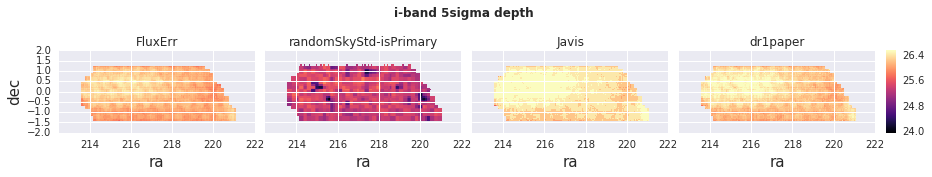

In [10]:
# just plot to see everything is ok
nCols= len(depthMap.keys())
cmap = cm.magma
xlabel, ylabel= 'ra', 'dec'
for band in bands:
    # plot the depth for each method.
    fig = plt.figure(figsize=(15, 10))
    # set up for colorbar
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1, nCols), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    # since have three maps, need colorange that ~works for all.
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(depthMap):
        ind= np.where(depthMap[method][band]>0)[0]
        colorMin= min(colorMin, np.percentile(depthMap[method][band][ind], 0))
        colorMax= max(colorMin, np.percentile(depthMap[method][band][ind], 95))
    # plot
    for mInd, method in enumerate(depthMap):
        ax= grid[mInd]
        image= ax.imshow(depthMap[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band %ssigma depth'%(band, SNRthreshold), fontweight="bold", )
    plt.subplots_adjust(top=1.6)
    plt.show()
   

#### Now need to find the limiting mags for each depth map. Consider i-band as the detection band.

In [11]:
HSCFieldTag= 'GAMA15H_forced'
band= 'i'

In [12]:
pixelNums= flatSkyGrid.pos2pix(HSCdata[HSCFieldTag]['ra'], HSCdata[HSCFieldTag]['dec'])

In [13]:
# find five sigma depth for each object. add columns to dataframe.
fiveSigCols= {}
for method in depthMap:
    fiveSigCols[method]= []
    print method
    for band in bands:
        key= '%s-%s-5sigmaDepth'%(method, band)
        fiveSigCols[method].append(key)
        HSCdata[HSCFieldTag][key]= depthMap[method][band][pixelNums]
    
    print 'Added cols: %s'%fiveSigCols[method]

FluxErr
Added cols: ['FluxErr-i-5sigmaDepth']
randomSkyStd-isPrimary
Added cols: ['randomSkyStd-isPrimary-i-5sigmaDepth']
Javis
Added cols: ['Javis-i-5sigmaDepth']
dr1paper
Added cols: ['dr1paper-i-5sigmaDepth']


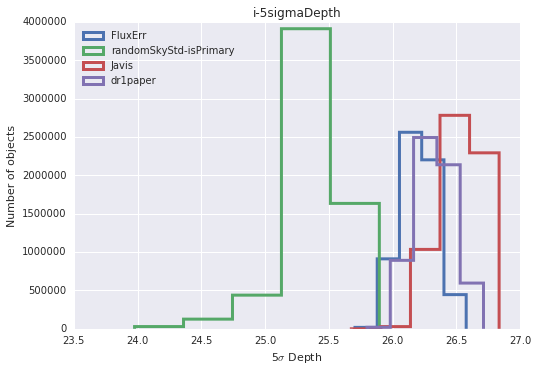

In [14]:
# plot histogram: number of objects we have for different depth bins
fig, ax = plt.subplots()
for method in depthMap:
    for key in fiveSigCols[method]:
        plt.hist(HSCdata[HSCFieldTag][key], label= method,
                 histtype= 'step', alpha= 1., lw= 3, bins= 5)
ax.legend(loc= "upper left")
ax.set_xlabel('5$\sigma$ Depth')
ax.set_ylabel('Number of objects')
ax.set_title(key.split(method+'-')[1])
plt.show()

Ok so distribution from random-skyStd differ quite a bit from the other two methods.

/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  '(shape is %d x %d)' % inp.shape[::-1])


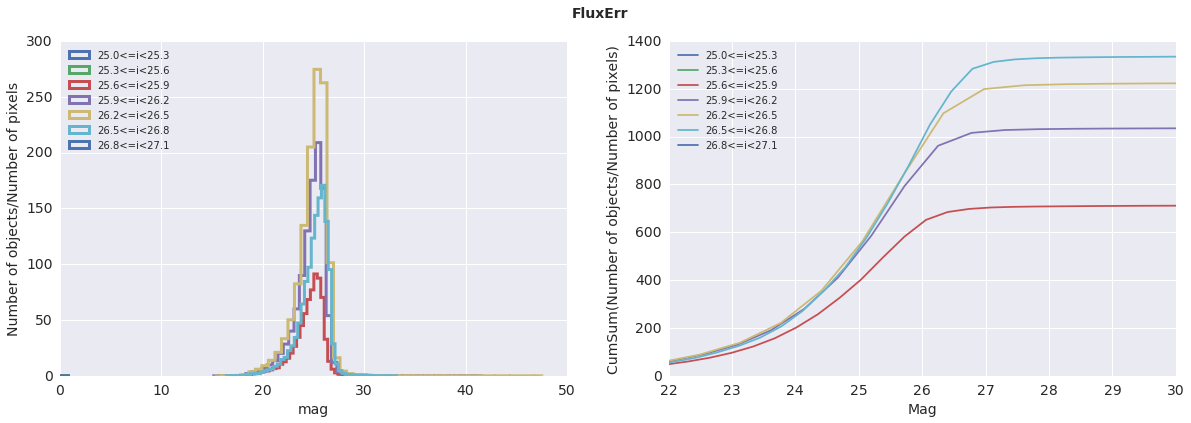

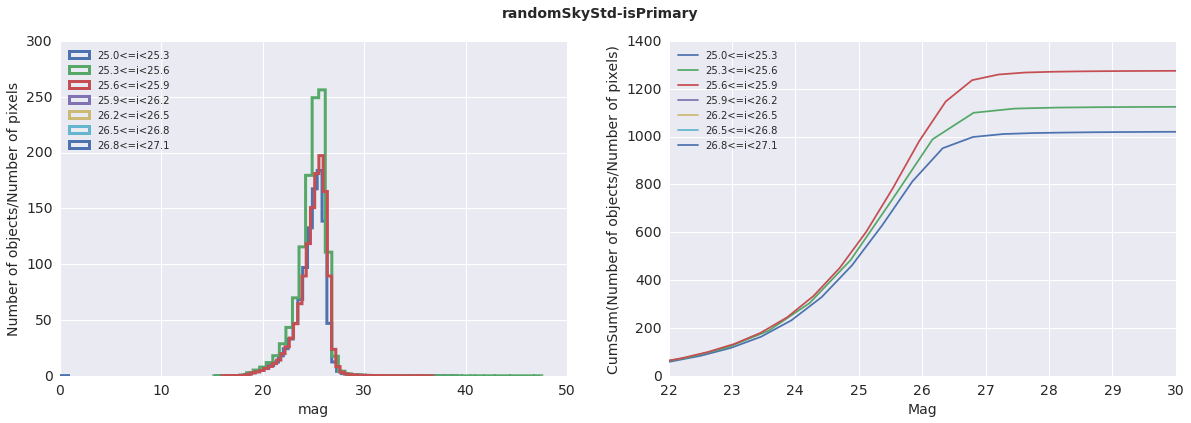

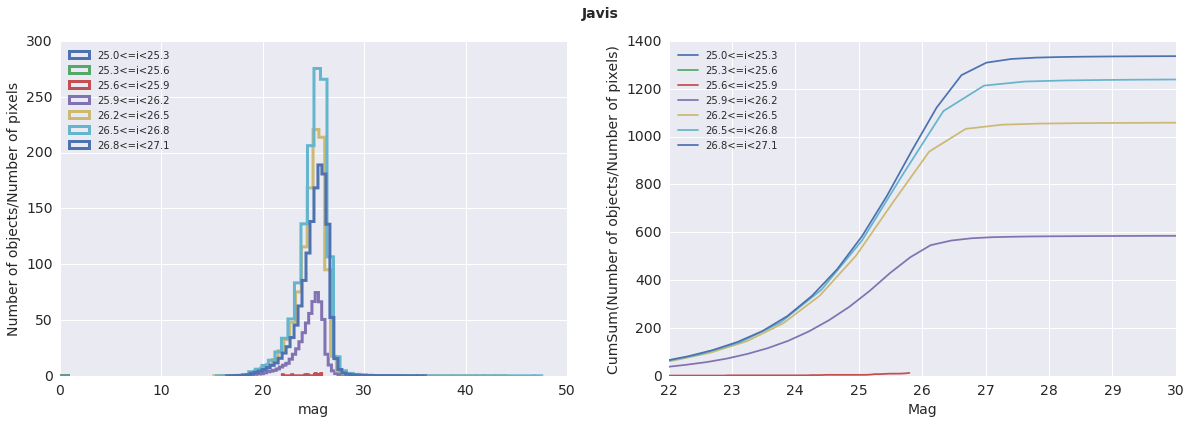

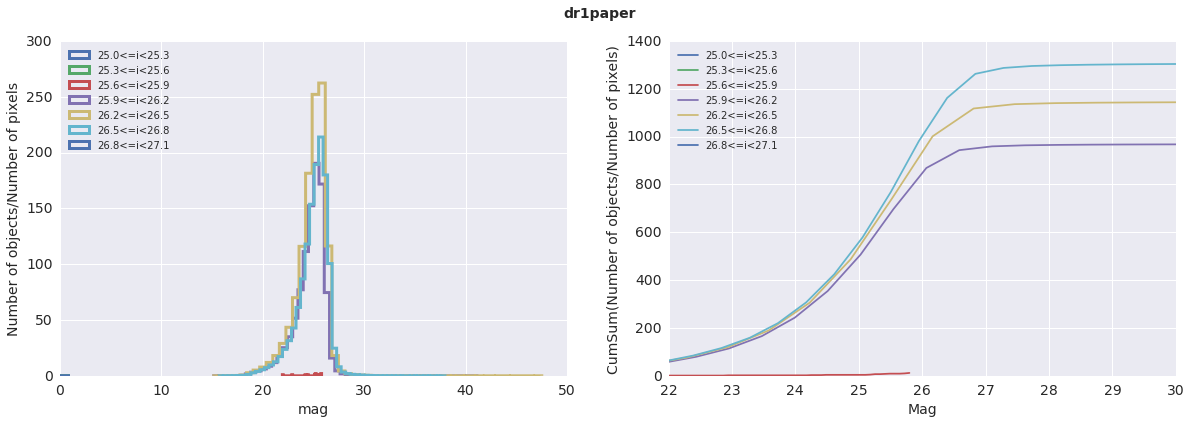

In [15]:
from collections import OrderedDict
densityTrend= OrderedDict()
for method in depthMap:
    fiveSigmaKey= '%s-%s-5sigmaDepth'%(method, band)
    densityTrend[method]= intermediates.getDensity_magCuts(depthmap= depthMap[method][band],
                                                           band= band,
                                                           galDepth= HSCdata[HSCFieldTag][fiveSigmaKey],
                                                           galMags= HSCdata[HSCFieldTag]['%scmodel_mag'%band],
                                                           depthRange= [25, 27], deldepthStep= 0.3,
                                                           plotTitle= method)

In [16]:
limitingMag= {'Javis': 26.0, 'randomSkyStd-isPrimary': 25.0, 'FluxErr': 25.8, 'dr1paper': 25.8}

#### Set up to run twoPt corr.

In [17]:
HSCFieldTag= 'GAMA15H_forced'

FluxErr
4122910 galaxies to consider.


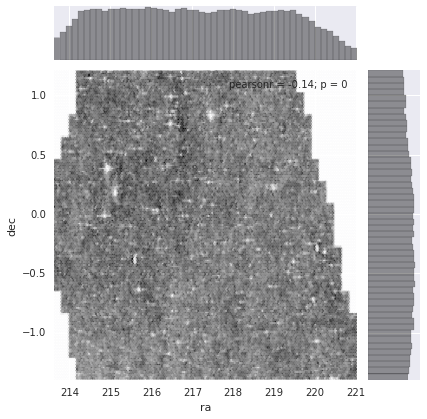

randomSkyStd-isPrimary
2535506 galaxies to consider.


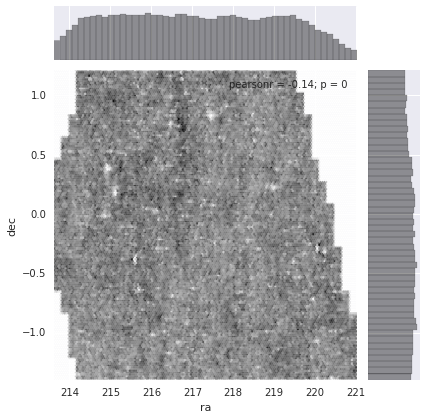

Javis
4465256 galaxies to consider.


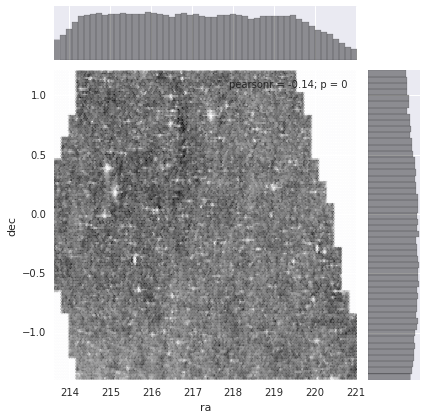

dr1paper
4122910 galaxies to consider.


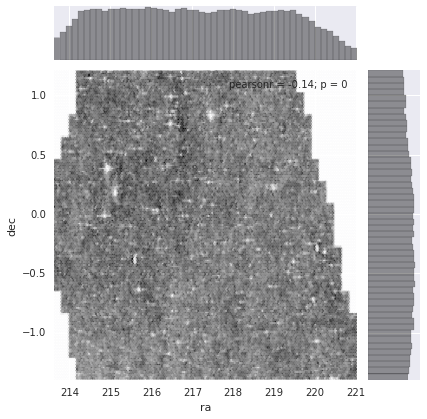

In [18]:
# find the mag-limited galaxy sample
galSample_ra, galSample_dec= {}, {}

for method in limitingMag:
    print method
    ind= np.where((HSCdata[HSCFieldTag]['%scmodel_mag'%band]<limitingMag[method]) & 
              (HSCdata[HSCFieldTag]['iclassification_extendedness']==1))[0]

    galSample_ra[method], galSample_dec[method]= HSCdata[HSCFieldTag]['ra'].iloc[ind], HSCdata[HSCFieldTag]['dec'].iloc[ind]
    print '%s galaxies to consider.'%len(galSample_ra[method])
    
    plt.clf()
    sns.jointplot(x=galSample_ra[method], y= galSample_dec[method], kind="hex", color="k")
    plt.show()

#### Random depth maps + random catalogs.

##### intermediates.getMask():

First create random-depth map: anything with i>limiting mag gets depth= 1. else depth= 0. go from HP pixels to ra, dec for random ra, dec catalog.

##### intermediates.getRandomCatalog():

Then create a uniform array in ra, sin(dec). Covert to pixel numbers, see which pixels fall in survey, and keep only the ra, decs that correspond to the 'good' pixels.

Then keep only the ra, dec from the uniform array that correspond to the pixels with depth= 1. in the random depth map.

FluxErr
Finding mask for i<25.8
randomSkyStd-isPrimary
Finding mask for i<25.0


/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Javis
Finding mask for i<26.0
dr1paper
Finding mask for i<25.8


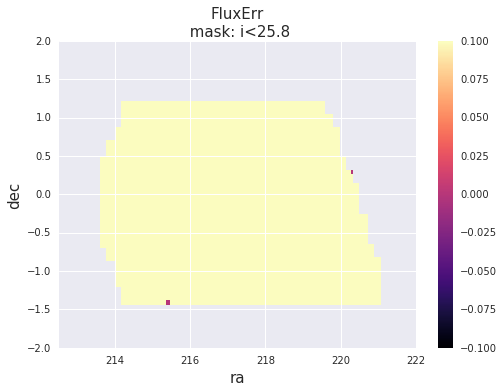

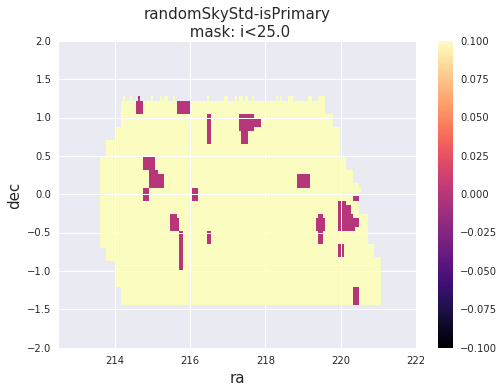

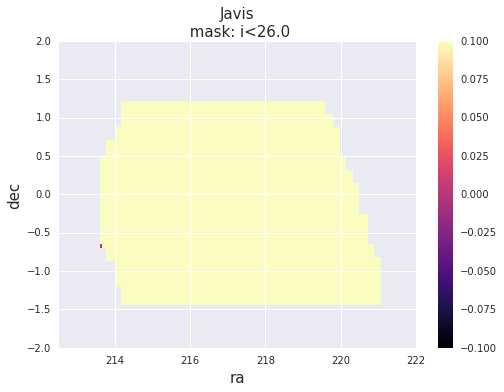

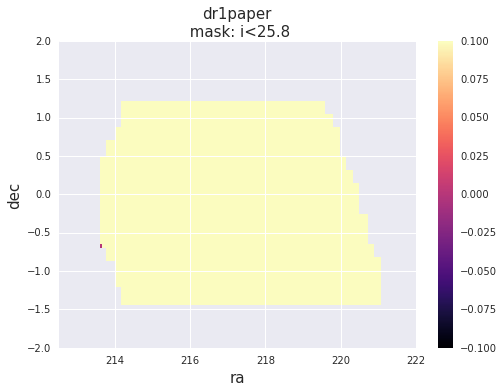

In [19]:
# random depth maps
masks= {}
for method in depthMap.keys():
    print method
    masks[method]= intermediates.getMask(depthMap[method][band], band, limitingMag[method],
                                         plotMap= True, flatSkyGrid= flatSkyGrid, title= method)

In [20]:
nData= 0
for method in depthMap:
    nData= max(nData, len(galSample_ra[method]))

In [21]:
randCatalog= {}
for method in depthMap:
    randCatalog[method]= intermediates.getRandomCatalog(flatSkyGrid, masks[method],
                                                        minRA= min(HSCdata[HSCFieldTag]['ra']),
                                                        maxRA= max(HSCdata[HSCFieldTag]['ra']),
                                                        minDec=  min(HSCdata[HSCFieldTag]['dec']),
                                                        maxDec=  max(HSCdata[HSCFieldTag]['dec']),
                                                        nData= nData, plotMap= False)

7982203 entries in the random catalog.
7545054 entries in the random catalog.
7984132 entries in the random catalog.
7983514 entries in the random catalog.


#### Run tree corr.

Running with 4122910 data pts, 7982203 random pts
Time taken: 399.415746212 (s)


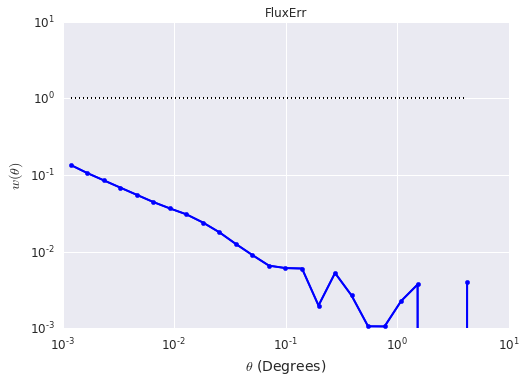

Running with 2535506 data pts, 7545054 random pts
Time taken: 296.447448015 (s)


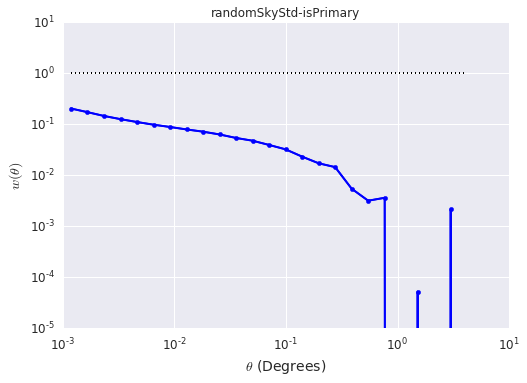

Running with 4465256 data pts, 7984132 random pts
Time taken: 379.861844063 (s)


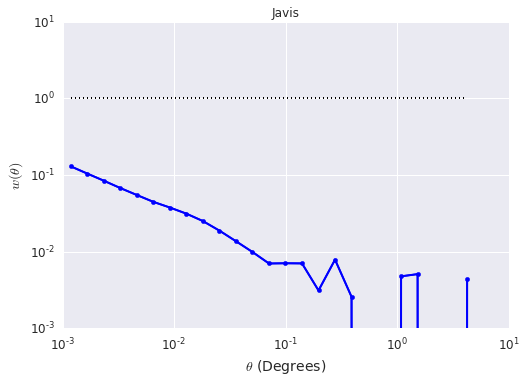

Running with 4122910 data pts, 7983514 random pts
Time taken: 370.618971109 (s)


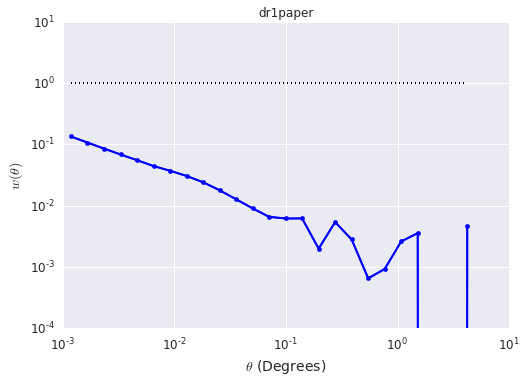

In [22]:
theta, wtheta, wtheta_sig= {}, {}, {}
for method in depthMap:
    theta[method], wtheta[method], wtheta_sig[method]= runTreeCorr(data_ra= galSample_ra[method],
                                                                   data_dec= galSample_dec[method],
                                                                   random_ra= randCatalog[method]['ra'],
                                                                   random_dec= randCatalog[method]['dec'],
                                                                   minSep= 0.001, maxSep= 5, nBins= 25)
    
    plot_wtheta(theta[method], wtheta[method], wtheta_sig[method], title= method)

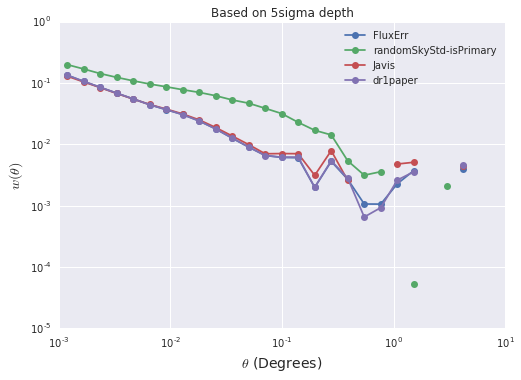

In [23]:
# overplot
for method in theta:
    plt.plot(theta[method], wtheta[method], 'o-', label= method)
plt.legend()
plt.title('Based on %ssigma depth'%SNRthreshold)
plt.xlabel(r'$\theta$ (Degrees)', fontsize= 14)
plt.ylabel(r'$w(\theta)$', fontsize= 14)
plt.loglog()
plt.show()

Ok Flux-Err and dr1paper methods for calculating 5sigma depth are practically the same. Javi's is quite similar too. random-sky-std is way different, so just ignore it from now on.